## 1. 리듀서(Reducer)란?

### 1.1 리듀서 없이 상태 업데이트하면 일어나는 일

In [1]:
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage
from typing_extensions import TypedDict, List, Annotated

class MyState(TypedDict):
    messages: List 

graph_builder = StateGraph(MyState)

def node_a(state):
    return {"messages": [HumanMessage(content="안녕")]}

def node_b(state):
    return {"messages": [AIMessage(content="반가워")]}

graph_builder.add_node("node_a", node_a)
graph_builder.add_node("node_b", node_b)

graph_builder.add_edge("node_a", "node_b")
graph_builder.set_entry_point("node_a")
graph_builder.set_finish_point("node_b")

graph = graph_builder.compile()

result = graph.invoke({"messages": []})
for i in result['messages']:
    i.pretty_print()


================================== Ai Message ==================================

반가워


### 1.2 리듀서를 사용하면?

In [2]:
from typing import Annotated
from langgraph.graph.message import add_messages

# 상태정의 (리듀서 적용)
class MyState(TypedDict):
    messages: Annotated[List, add_messages]

graph_builder = StateGraph(MyState)

def node_a(state):
    return {"messages": [HumanMessage(content="안녕")]}

def node_b(state):
    return {"messages": [AIMessage(content="반가워")]}

graph_builder.add_node("node_a", node_a)
graph_builder.add_node("node_b", node_b)

graph_builder.add_edge("node_a", "node_b")
graph_builder.set_entry_point("node_a")
graph_builder.set_finish_point("node_b")

graph = graph_builder.compile()

# 실행 
result = graph.invoke({"messages": []})
for i in result['messages']:
    i.pretty_print()

================================ Human Message =================================

안녕
================================== Ai Message ==================================

반가워


## 2. 리듀서를 활용한 LangGraph로 나만의 여행 계획 챗봇 만들기

### 2.1 여행 관련 도구 만들기 : 관광지, 항공권, 일정

In [3]:
from langchain_core.tools import tool 
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition 

In [4]:
# 1. 도시별 관광명소 도구
@tool
def get_attractions(city: str) -> str:
    """
    주어진 도시의 인기 관광명소를 한국어로 반환하는 함수입니다.
    """
    attractions = {
        "서울": "경복궁, N서울타워, 명동",
        "부산": "해운대, 광안리, 자갈치시장",
        "제주": "한라산, 성산일출봉, 만장굴"
    }
    return attractions.get(city, "정보 없음")

# 2. 항공권 가격 도구
@tool
def get_flight_price(departure: str, destination: str, date: str) -> str:
    '''
    출발지, 도착지, 날짜를 입력받아 항공권 가격을 한국어로 반환하는 함수입니다.
    '''
    prices = {
        ("서울", "부산"): 50000,
        ("서울", "제주"): 70000,
        ("부산", "제주"): 60000
    }

    # 경로확인 
    route = (departure, destination)
    if route in prices:
        price = prices[route]
        return f"{date}에 {departure}에서 {destination}까지의 항공권 가격은 {price}원입니다."
    else:
        return "해당 경로의 항공권 정보가 없습니다."
    
# 3. 여행 일정 추천 도구
@tool
def recommend_itinerary(city: str, days: int) -> str:
    '''
    도시와 여행 일수를 입력받아 추천 일정을 한국어로 반환하는 함수입니다.
    '''
    itineraries = {
        "서울": {
            1: "경복궁 방문, 명동 쇼핑",
            2: "N서울타워, 한강공원 산책",
            3: "홍대 거리, 이태원 탐방"
        },
        "부산": {
            1: "해운대 해수욕장, 광안리 야경",
            2: "자갈치시장, 감천문화마을",
            3: "태종대, 부산타워"
        },
        "제주": {
            1: "한라산 등반, 성산일출봉",
            2: "만장굴 탐험, 협재해변",
            3: "우도 여행, 제주 민속촌"
        }
    }

    if city not in recommend_itinerary:
        return "해당 도시의 추천 일정 정보가 없습니다."
    
    # 해당 도시의 활동 목록
    activities = itineraries[city]

    # 포맷팅된 문자열로 일정 생성
    result = f"{city}에서의 {days}일 여행 추천 일정:\n"

    for day in range(1, days + 1):
        morning = activities[(day * 3 - 3) % len(activities)]
        afternoon = activities[(day * 3 - 2) % len(activities)]
        evening = activities[(day * 3 - 1) % len(activities)]


        result += f"### Day {day}:\n"
        result += f"- 아침: {morning}\n"
        result += f"- 오후: {afternoon}\n"
        result += f"- 저녁: {evening}\n"

    return result

In [5]:
# 4. 최종적으로 사용할 도구 목록
tools = [get_attractions, get_flight_price, recommend_itinerary]

### 2.2 도구 사용을 위한 LLM 준비 및 어시스턴트 정의

In [6]:
from typing_extensions import TypedDict
from dotenv import load_dotenv
import os

# .env 파일 로드
load_dotenv()

# 1. 상태(State) 타입 정의 - TravelChatbot
class TravelChatbot(TypedDict):
    messages: Annotated[list, add_messages]

# 2. LLM 바인딩 및 시스템 메시지 설정
llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

sys_msg = SystemMessage(content="당신은 여행 계획을 도와주는 여행 전문 에이전트입니다. 사용자의 요청을 이해하고 적절한 도구를 순차적으로 사용하여 여행 계획을 세워주세요.")

# 3. assistatnt 노드 정의
def assistant(state: TravelChatbot):
    # (1) 시스템 메시지 + 누적된 대화내역(state['messages']) 을 LLM에 전달
    messages = [sys_msg] + state['messages']
    # (2) LLM에게 메시지 리스트를 넘겨서 응답 생성
    response = llm_with_tools.invoke(messages)
    # (3) 새로 생성된 AIMessage를 "messages" 상태에 추가하여 반환하면
    #     add_messages 리듀서가 자동으로 state['messages']에 누적시켜줌
    return {"messages" :[response]}

# 4. ToolNode 생성
tool_node = ToolNode(tools)

### 2.3 멀티턴 대화를 지원하는 상태기반 그래프 만들기

In [7]:
# TravelChatbot 상태 타입을 인자로 넣어서 그래프 빌더 생성
builder = StateGraph(TravelChatbot)

builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()

In [8]:
graph.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
        +-----------+         
        | assistant |         
        +-----------+         
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


### 2.4 실제 여행 요청에 대한 그래프 실행 및 결과 출력

In [9]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=
                         "첫째, 서울의 상위 5개 관광명소를 알려줘."
                         "그 다음, 서울->부산 7월 15일 항공권 가격도 알려주고,"
                         "마지막으로 부산 3일 일정 추천해줘.")]
result = graph.invoke({"messages": messages})

for msg in result['messages']:
    msg.pretty_print()

================================ Human Message =================================

첫째, 서울의 상위 5개 관광명소를 알려줘.그 다음, 서울->부산 7월 15일 항공권 가격도 알려주고,마지막으로 부산 3일 일정 추천해줘.
================================== Ai Message ==================================
Tool Calls:
  get_attractions (call_6jXxKvQwk3XpeVlUErmg5yPv)
 Call ID: call_6jXxKvQwk3XpeVlUErmg5yPv
  Args:
    city: 서울
================================= Tool Message =================================
Name: get_attractions

경복궁, N서울타워, 명동
================================== Ai Message ==================================
Tool Calls:
  get_flight_price (call_cSKVpDozLnBILW98pJnMo2JG)
 Call ID: call_cSKVpDozLnBILW98pJnMo2JG
  Args:
    departure: 서울
    destination: 부산
    date: 2023-07-15
================================= Tool Message =================================
Name: get_flight_price

2023-07-15에 서울에서 부산까지의 항공권 가격은 50000원입니다.
================================== Ai Message ==================================
Tool Calls:
  recommend_itinerary (cal

## 3. MessagesState 상속으로 counter 필드 추가하기

### 3.1 사용할 도구 목록

In [10]:
tools = [get_attractions, get_flight_price, recommend_itinerary]

### 3.2 상태(State)정의 : MessagesState 상속 + 카운터 필드 추가

In [11]:
class TravelChatbot(MessagesState):
    counter: int 

### 3.3 LLM 바인딩

In [12]:
llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

### 3.4 assistant 노드 정의: counter를 활용해 대화 턴 수를 관리

In [13]:
def assistant(state: TravelChatbot):
    # 4.1 이전 counter 값을 꺼내서 + 1
    current_counter = state.get("counter", 0) + 1

    # 4.2 카운터 정보를 시스템 메시지에 추가
    enhanced_sys_msg = SystemMessage(
        content=f"당신은 여행 계획을 도와주는 여행 전문 에이전트입니다. 현재 대화 횟수는 {current_counter}회입니다. 사용자의 요청을 이해하고 적절한 도구를 순차적으로 사용하여 여행 계획을 세워주세요."
    )

    # 4.3 이전 메시지(history)와 시스템 메시지를 합쳐서 LLM에 전달
    messages = [enhanced_sys_msg] + state['messages']
    response = llm_with_tools.invoke(messages)

    # 4.4 새로 생성된 응답 메시지와 업데이트된 counter를 반환
    return {
        "messages": [response],
        "counter": current_counter
    }

### 3.5 ToolNode 생성 및 StateGraph 빌드

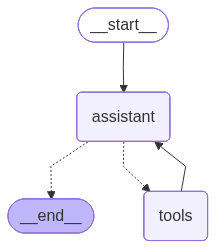

In [14]:
tool_node = ToolNode(tools)

builder = StateGraph(TravelChatbot) 

builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()   
graph

### 3.6 그래프 실행 예시: counter 0으로 초기화

In [15]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=
    "첫째, 서울의 상위 5개 관광명소를 알려줘. "
    "그 다음, 서울->부산 7월 15일 항공권 가격도 알려주고,"
    "마지막으로 부산 3일 일정 추천해줘."
)]

result = graph.invoke({
    "messages": messages,
    "counter": 0
})

print("대화 횟수:", result['counter'])

for msg in result['messages']:
    msg.pretty_print()

대화 횟수: 4
================================ Human Message =================================

첫째, 서울의 상위 5개 관광명소를 알려줘. 그 다음, 서울->부산 7월 15일 항공권 가격도 알려주고,마지막으로 부산 3일 일정 추천해줘.
================================== Ai Message ==================================
Tool Calls:
  get_attractions (call_33GMyGenG7ajnOHhNadGfcbE)
 Call ID: call_33GMyGenG7ajnOHhNadGfcbE
  Args:
    city: 서울
================================= Tool Message =================================
Name: get_attractions

경복궁, N서울타워, 명동
================================== Ai Message ==================================
Tool Calls:
  get_flight_price (call_excE18BDhMaA1p5lxDsg4apF)
 Call ID: call_excE18BDhMaA1p5lxDsg4apF
  Args:
    departure: 서울
    destination: 부산
    date: 2024-07-15
================================= Tool Message =================================
Name: get_flight_price

2024-07-15에 서울에서 부산까지의 항공권 가격은 50000원입니다.
================================== Ai Message ==================================
Tool Calls:
  recommend_itin

## 4. operator.add 리듀서로 자동 카운터 구현하기

### 4.1 사용할 도구(tool) 목록

In [16]:
tools = [get_attractions, get_flight_price, recommend_itinerary]

### 4.2 상태(state) 정의: TypedDict상속 + 리듀서 지정

In [17]:
import operator

class TravelChatbot(TypedDict):
    messages: Annotated[list, add_messages]
    counter: Annotated[int, operator.add]

### 4.3 LLM 바인딩

In [18]:
llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

### 4.4 assistant 노드 정의: counter를 활용해 대화 턴수를 관리

In [19]:
def assistant(state: TravelChatbot):
    # 4.1 카운터 정보를 시스템 메시지에 추가
    enhanced_sys_msg = SystemMessage(content="당신은 여행 계획을 도와주는 여행 전문 에이전트입니다. 사용자의 요청을 이해하고 적절한 도구를 순차적으로 사용하여 여행 계획을 세워주세요.")

    # 4.2 이전 메시지(history)와 시스템 메시지를 합쳐서 LLM에 전달
    messages = [enhanced_sys_msg] + state['messages']
    response = llm_with_tools.invoke(messages)

    # operator.add 리듀서를 활용: counter에 1을 반환하면 자동으로 기존 값에 더해짐
    return {
        "messages": [response],
        "counter": 1  # operator.add 리듀서가 자동으로 기존 값에 더해줌
    }

### 4.5 ToolNode 생성 및 StateGraph 빌드

In [20]:
tool_node = ToolNode(tools)

builder = StateGraph(TravelChatbot)

builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()

### 4.6 그래프 실행 예시: counter 0으로 초기화

In [21]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=
    "첫째, 서울의 상위 5개 관광명소를 알려줘. "
    "그 다음, 서울->부산 7월 15일 항공권 가격도 알려주고,"
    "마지막으로 부산 3일 일정 추천해줘."
)]

result = graph.invoke({
    "messages": messages,
    "counter": 0
})

print("대화 횟수:", result['counter'])
for msg in result['messages']:
    msg.pretty_print()

대화 횟수: 4
================================ Human Message =================================

첫째, 서울의 상위 5개 관광명소를 알려줘. 그 다음, 서울->부산 7월 15일 항공권 가격도 알려주고,마지막으로 부산 3일 일정 추천해줘.
================================== Ai Message ==================================
Tool Calls:
  get_attractions (call_EcSqJf2pnxYAqikYyX5zRjVm)
 Call ID: call_EcSqJf2pnxYAqikYyX5zRjVm
  Args:
    city: 서울
================================= Tool Message =================================
Name: get_attractions

경복궁, N서울타워, 명동
================================== Ai Message ==================================
Tool Calls:
  get_flight_price (call_uf9gLoixOL7KLbzBaweaBG2k)
 Call ID: call_uf9gLoixOL7KLbzBaweaBG2k
  Args:
    departure: 서울
    destination: 부산
    date: 2024-07-15
================================= Tool Message =================================
Name: get_flight_price

2024-07-15에 서울에서 부산까지의 항공권 가격은 50000원입니다.
================================== Ai Message ==================================
Tool Calls:
  recommend_itin